In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import dual_annealing as anneal_algo
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate 
import pysindy as ps

# Atmospheric attractor parameters
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps*k1
mu2 = -eps*k2
alpha = -2.0
omega = 3.0

dt = 0.01
T = 500
t = np.arange(0,T+dt,dt)
tmax = len(t)-1

def oscillator_deriv(x_y_z, t0):
    x, y, z = x_y_z
    return [mu1*x + sigma*x*y, mu2*y + (omega + alpha*y + beta*z)*z - sigma*x**2, mu2*z - (omega + alpha*y + beta*z)*y]

x0_train = [0.1, -0.1, 0.1]
x_t = integrate.odeint(oscillator_deriv, x0_train, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0_train))

# Add some noise to the data
mean = 0.0
variance = 0.01
np.random.seed(502)
noise = np.random.normal(mean,variance,x_t.shape[0])
for i in range(r):
    x_t[:,i] = x_t[:,i] + noise

In [2]:
# Define all the complicated matrices in the optimization
poly_order = 2
Nr = int((r**2 + 3*r)/2.0)
mean = 0.0
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), int(r*(r**2+3*r)/2)))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1
# delta_{il}delta_{jk}
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0

# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

PQ_tensor = np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0  # opt_m[k]  

    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0  # opt_m[j]

# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)

x, y, z = x_t.T

if poly_order == 2:
    library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
    library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
else:
    library_functions = [lambda x:x]
    library_function_names = [lambda x:x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                    function_names=library_function_names)

In [3]:
# Define the hyperparams and perform the optimization (regular prox-gradient)
eta = 1.0e2
gamma = 1.0/eta
beta = 0.5
threshold = 0.1
sindy_opt = ps.clSR3(threshold=threshold, eta=eta, alpha_m=gamma, alpha_A=beta, vtol=1e-5, accel=False,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=40000, tol=1e-10,
                            thresholder="l1", eigmin=-1e50, eigmax=-0.01,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")

model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True),
        )
model.fit(x_t, t=t)
Xi = model.coefficients().T

# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
eigvals, eigvecs = np.linalg.eig(As)
print('proxgrad, As eigvals: ', eigvals)
print(opt_m)
smallest_eigval = np.sort(eigvals)[0]
largest_eigval = np.sort(eigvals)[-1]
L = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2],[0])), opt_m)
Rm = np.sqrt(smallest_eigval/largest_eigval)*np.linalg.norm(d)
print(d, Rm)

model.print()
print(np.dot(constraint_matrix, (sindy_opt.history_[0]).T.flatten()))
print(np.dot(constraint_matrix, (sindy_opt.history_[1]).T.flatten()))

37749.495840374715 2.538652842341664e-05 2.2461592302033786
37750.11365717662 4.793948186728453e-08 2.2269210894785525
37750.11365717662 2.1998213599438316e-08 2.2269210894785525
37750.11365422266 2.1789754275307932e-08 2.22692197055374
37750.113654221794 2.1733238984227962e-08 2.226921971515072
37750.11365422108 2.167815312392039e-08 2.2269219723004157
37750.11365422036 2.1623534957435363e-08 2.2269219730781904
37750.11365421966 2.156915271645838e-08 2.2269219738448323
37750.11365421895 2.1514949417160386e-08 2.2269219746025954
37750.11365421827 2.1460910637471587e-08 2.2269219753544065
37750.11365421759 2.1407032400910102e-08 2.2269219761022625
37750.1136542169 2.135331330593032e-08 2.2269219768474366
37750.11365421621 2.1299752588926112e-08 2.2269219775905986
37750.11365421552 2.1246349645697675e-08 2.2269219783322187
37750.113654214845 2.119310391474687e-08 2.226921979072447
37750.11365421416 2.114001484519211e-08 2.2269219798114217
37750.113654213485 2.108708189162091e-08 2.226921

37750.11365412621 1.488953559616157e-08 2.226922075400524
37750.113654125664 1.48543605609604e-08 2.226922075996288
37750.11365412512 1.4819281722810077e-08 2.2269220765911584
37750.113654124565 1.4784298774573531e-08 2.226922077185207
37750.11365412402 1.4749411408900135e-08 2.226922077778404
37750.11365412348 1.4714619320474074e-08 2.226922078370756
37750.113654122935 1.4679922205225697e-08 2.2269220789622692
37750.11365412239 1.464531975911571e-08 2.2269220795529203
37750.113654121844 1.4610811680553042e-08 2.2269220801427596
37750.11365412131 1.4576397668316189e-08 2.226922080731742
37750.11365412076 1.45420774225902e-08 2.2269220813198913
37750.11365412022 1.4507850644651135e-08 2.2269220819071704
37750.113654119676 1.4473717036633173e-08 2.226922082493659
37750.11365411915 1.4439676302092466e-08 2.226922083079284
37750.113654118606 1.4405728145727199e-08 2.226922083664087
37750.11365411807 1.4371872272603668e-08 2.226922084248061
37750.11365411753 1.4338108389911673e-08 2.2269220

37750.11365404802 1.0328644795147612e-08 2.2269221604066867
37750.11365404758 1.030554372455751e-08 2.2269221608851946
37750.11365404714 1.0282501616101483e-08 2.2269221613630235
37750.113654046705 1.025951829551541e-08 2.226922161840237
37750.11365404627 1.0236593589368883e-08 2.2269221623168076
37750.11365404583 1.0213727324619329e-08 2.2269221627927154
37750.11365404539 1.0190919328640056e-08 2.2269221632680263
37750.11365404496 1.0168169429962832e-08 2.226922163742708
37750.113654044515 1.0145477456710048e-08 2.2269221642167505
37750.11365404407 1.012284323886309e-08 2.2269221646901705
37750.11365404364 1.0100266606081561e-08 2.2269221651629443
37750.11365404321 1.0077747388771217e-08 2.2269221656351124
37750.11365404278 1.0055285418009622e-08 2.2269221661066463
37750.11365404235 1.0032880525737433e-08 2.2269221665775634
37750.11365404192 1.0010532543960988e-08 2.22692216704786
37750.11365404148 9.988241305467868e-09 2.2269221675175213
37750.11365404105 9.966006643866169e-09 2.2269

37750.1136539848 7.29530217369263e-09 2.2269222291681428
37750.113653984445 7.279727207538206e-09 2.226922229557977
37750.113653984095 7.26418968674838e-09 2.226922229947385
37750.11365398373 7.248689508527437e-09 2.2269222303362435
37750.113653983375 7.233226569939293e-09 2.226922230724648
37750.11365398302 7.217800768490928e-09 2.2269222311125563
37750.113653982655 7.20241200221319e-09 2.2269222314999833
37750.113653982306 7.187060169321193e-09 2.226922231886923
37750.11365398195 7.171745168100655e-09 2.226922232273363
37750.1136539816 7.156466897575441e-09 2.226922232659365
37750.11365398124 7.141225257041902e-09 2.226922233044867
37750.11365398088 7.1260201455927505e-09 2.226922233429858
37750.11365398052 7.110851463459562e-09 2.226922233814418
37750.11365398018 7.095719110422094e-09 2.226922234198512
37750.11365397983 7.080622987144262e-09 2.2269222345820863
37750.113653979475 7.065562994182057e-09 2.22692223496519
37750.11365397912 7.050539032776235e-09 2.2269222353478426
37750.1

37750.11365393301 5.228988109216802e-09 2.226922285522779
37750.113653932705 5.218259818278883e-09 2.226922285844217
37750.11365393242 5.207556013996594e-09 2.2269222861652347
37750.11365393213 5.196876633472722e-09 2.2269222864858755
37750.11365393183 5.186221613257428e-09 2.2269222868061758
37750.11365393153 5.175590890540821e-09 2.226922287126085
37750.113653931236 5.164984402632791e-09 2.2269222874455896
37750.11365393095 5.154402086684359e-09 2.2269222877647405
37750.11365393066 5.14384388047908e-09 2.226922288083496
37750.113653930355 5.133309721635599e-09 2.226922288401908
37750.113653930064 5.122799548389794e-09 2.2269222887199147
37750.11365392977 5.1123132985789016e-09 2.2269222890375615
37750.11365392949 5.101850910725901e-09 2.2269222893548326
37750.11365392919 5.091412323421876e-09 2.226922289671714
37750.1136539289 5.080997475151941e-09 2.2269222899882677
37750.11365392861 5.070606304814301e-09 2.2269222903044117
37750.11365392831 5.0602387514883365e-09 2.2269222906202017

37750.113653890345 3.801018177235119e-09 2.22692233194249
37750.113653890105 3.793479930586794e-09 2.226922332210394
37750.113653889865 3.785958132166728e-09 2.2269223324779692
37750.11365388961 3.778452741616817e-09 2.2269223327452594
37750.11365388937 3.770963718670695e-09 2.226922333012255
37750.11365388912 3.76349102358202e-09 2.2269223332789525
37750.11365388889 3.756034616280805e-09 2.2269223335453456
37750.11365388865 3.7485944570136735e-09 2.226922333811433
37750.11365388839 3.741170505913062e-09 2.2269223340772193
37750.113653888155 3.73376272365948e-09 2.2269223343427096
37750.1136538879 3.726371070514165e-09 2.226922334607908
37750.11365388766 3.71899550726823e-09 2.2269223348728047
37750.11365388742 3.7116359945749713e-09 2.2269223351374037
37750.11365388718 3.7042924933478634e-09 2.2269223354017282
37750.11365388693 3.6969649644455955e-09 2.226922335665726
37750.11365388669 3.689653368931623e-09 2.226922335929428
37750.11365388645 3.6823576682269717e-09 2.2269223361928385


37750.11365385447 2.7851881838476163e-09 2.2269223710129302
37750.113653854256 2.77982487190543e-09 2.2269223712377935
37750.11365385406 2.7744728080224896e-09 2.2269223714623814
37750.11365385384 2.76913196614681e-09 2.2269223716867352
37750.113653853645 2.76380232004176e-09 2.2269223719108866
37750.11365385343 2.7584838437529667e-09 2.226922372134763
37750.11365385323 2.7531765111168855e-09 2.2269223723584206
37750.113653853026 2.747880296407639e-09 2.226922372581801
37750.11365385281 2.742595173565074e-09 2.226922372804976
37750.11365385261 2.7373211169831295e-09 2.2269223730278935
37750.11365385241 2.732058100859782e-09 2.226922373250566
37750.113653852204 2.7268060995900084e-09 2.226922373473012
37750.11365385199 2.7215650874487376e-09 2.226922373695218
37750.1136538518 2.7163350389264047e-09 2.2269223739171906
37750.113653851586 2.711115928802306e-09 2.2269223741389004
37750.11365385139 2.7059077314124765e-09 2.2269223743603916
37750.11365385119 2.7007104215471178e-09 2.226922374

37750.11365382424 2.0580980964497065e-09 2.2269224039180027
37750.11365382407 2.0542345563261124e-09 2.2269224041080142
37750.113653823886 2.050378843019122e-09 2.226922404297822
37750.11365382372 2.0465309389002655e-09 2.226922404487481
37750.11365382354 2.0426908267343024e-09 2.2269224046769085
37750.11365382336 2.0388584892824033e-09 2.2269224048661247
37750.113653823195 2.0350339089719746e-09 2.2269224050551863
37750.11365382302 2.031217068681614e-09 2.2269224052440117
37750.113653822846 2.0274079511933266e-09 2.2269224054326506
37750.11365382267 2.0236065392104554e-09 2.2269224056211168
37750.11365382249 2.0198128156742627e-09 2.2269224058093755
37750.11365382234 2.0160267634946294e-09 2.226922405997442
37750.113653822154 2.01224836554806e-09 2.226922406185321
37750.11365382199 2.0084776047695583e-09 2.226922406372984
37750.11365382181 2.004714464335707e-09 2.2269224065604702
37750.11365382164 2.0009589271720453e-09 2.2269224067477515
37750.11365382147 1.997210976489764e-09 2.2269

37750.113653798624 1.5316626814517677e-09 2.2269224318070457
37750.11365379847 1.5288501620319417e-09 2.226922431968609
37750.113653798326 1.5260431698554757e-09 2.226922432129956
37750.11365379818 1.5232416928920756e-09 2.2269224322911625
37750.113653798035 1.52044571956141e-09 2.2269224324521995
37750.11365379788 1.5176552379616427e-09 2.226922432613079
37750.113653797736 1.5148702362650028e-09 2.2269224327738235
37750.11365379759 1.512090702872938e-09 2.226922432934352
37750.113653797445 1.5093166259897922e-09 2.2269224330947703
37750.11365379729 1.5065479939722833e-09 2.22692243325498
37750.11365379715 1.5037847951403228e-09 2.22692243341508
37750.113653797 1.5010270178836531e-09 2.226922433574989
37750.113653796856 1.4982746505637592e-09 2.2269224337347433
37750.11365379672 1.4955276817634733e-09 2.226922433894348
37750.11365379657 1.4927860996725547e-09 2.2269224340537845
37750.11365379642 1.490049893036948e-09 2.2269224342130465
37750.113653796274 1.4873190501764007e-09 2.226922

37750.11365377681 1.1467773199221841e-09 2.226922455572458
37750.11365377669 1.1447115517695926e-09 2.2269224557104446
37750.113653776556 1.1426497366336988e-09 2.226922455848289
37750.113653776425 1.140591866264982e-09 2.226922455985986
37750.1136537763 1.1385379324014647e-09 2.2269224561235936
37750.11365377616 1.1364879270641809e-09 2.2269224562610392
37750.11365377605 1.1344418419458191e-09 2.2269224563983507
37750.113653775916 1.1323996690912357e-09 2.2269224565355503
37750.11365377579 1.130361400365343e-09 2.226922456672601
37750.113653775676 1.1283270276510378e-09 2.2269224568094947
37750.113653775545 1.1262965429808208e-09 2.2269224569462884
37750.11365377542 1.1242699382219097e-09 2.226922457082944
37750.1136537753 1.1222472054013867e-09 2.226922457219444
37750.11365377517 1.1202283365315345e-09 2.2269224573558417
37750.11365377505 1.1182133236433155e-09 2.226922457492089
37750.11365377492 1.1162021587283108e-09 2.22692245762822
37750.113653774795 1.114194833874143e-09 2.22692

37750.11365375813 8.630365744421013e-10 2.2269224759170942
37750.11365375802 8.615076725915924e-10 2.2269224760354867
37750.113653757915 8.599816287419388e-10 2.226922476153781
37750.11365375779 8.584584371057205e-10 2.226922476271914
37750.1136537577 8.569380919825139e-10 2.226922476389949
37750.11365375758 8.554205876196863e-10 2.2269224765078928
37750.11365375748 8.539059183159327e-10 2.2269224766257256
37750.11365375737 8.523940785148043e-10 2.226922476743414
37750.11365375727 8.508850623969316e-10 2.226922476861025
37750.113653757144 8.493788643763717e-10 2.2269224769784906
37750.11365375705 8.47875478732939e-10 2.2269224770958496
37750.11365375694 8.463748999671286e-10 2.2269224772131118
37750.11365375683 8.448771223023424e-10 2.226922477330261
37750.11365375672 8.433821402363448e-10 2.226922477447285
37750.11365375662 8.41889948106789e-10 2.226922477564235
37750.1136537565 8.404005403403688e-10 2.226922477681016
37750.1136537564 8.389139114318696e-10 2.226922477797746
37750.1136

37750.11365374208 6.523693157786855e-10 2.226922493402108
37750.11365374198 6.512303269611844e-10 2.226922493504041
37750.113653741886 6.500934238991214e-10 2.226922493605874
37750.1136537418 6.489586025553146e-10 2.2269224937076095
37750.1136537417 6.478258588480818e-10 2.2269224938092482
37750.11365374161 6.466951887122175e-10 2.2269224939107657
37750.11365374151 6.455665881087964e-10 2.2269224940122423
37750.11365374142 6.444400530026444e-10 2.2269224941135968
37750.11365374133 6.433155793821576e-10 2.2269224942148678
37750.11365374124 6.421931631751846e-10 2.2269224943160264
37750.11365374115 6.410728004231282e-10 2.226922494417122
37750.11365374105 6.399544870909159e-10 2.2269224945180803
37750.113653740955 6.388382191937865e-10 2.226922494618981
37750.113653740875 6.37723992799374e-10 2.226922494719765
37750.11365374078 6.366118038319115e-10 2.2269224948204807
37750.11365374069 6.355016483640595e-10 2.2269224949210673
37750.11365374059 6.343935224525939e-10 2.226922495021618
3775

37750.1136537288 5.010151484353678e-10 2.226922507861786
37750.113653728724 5.001510146387575e-10 2.2269225079503765
37750.113653728644 4.992884360698911e-10 2.226922508038929
37750.113653728564 4.984274098331321e-10 2.2269225081273656
37750.11365372848 4.975679328685243e-10 2.2269225082157087
37750.11365372839 4.967100022716708e-10 2.226922508303995
37750.11365372832 4.958536151348198e-10 2.226922508392164
37750.11365372823 4.949987684983353e-10 2.226922508480281
37750.113653728156 4.941454593842394e-10 2.226922508568297
37750.113653728076 4.932936848654129e-10 2.226922508656275
37750.113653727996 4.924434420530339e-10 2.2269225087441384
37750.1136537279 4.915947280467111e-10 2.2269225088319398
37750.11365372783 4.90747539860288e-10 2.2269225089196616
37750.113653727756 4.899018746801509e-10 2.2269225090072737
37750.113653727676 4.890577295499796e-10 2.226922509094834
37750.11365372759 4.882151015542104e-10 2.226922509182302
37750.11365372751 4.873739878595894e-10 2.2269225092697114
3

37750.11365371676 3.8134985888235453e-10 2.2269225209853025
37750.11365371669 3.8069943749617617e-10 2.226922521062061
18 : threshold not satisfying optimality, reduce the value
37750.11365371662 3.800501681988494e-10 2.2269225211387016
37750.11365371654 3.794020487416804e-10 2.2269225212152737
37750.11365371647 3.787550769923365e-10 2.2269225212917902
37750.11365371641 3.781092508907906e-10 2.226922521368268
37750.11365371634 3.77464568233162e-10 2.2269225214446284
37750.11365371627 3.7682102694025874e-10 2.2269225215209345
37750.11365371619 3.761786247914143e-10 2.226922521597182
37750.11365371612 3.755373597530747e-10 2.226922521673348
37750.113653716064 3.748972296755486e-10 2.226922521749467
37750.113653716 3.742582324932819e-10 2.226922521825499
18 : threshold not satisfying optimality, reduce the value
37750.11365371591 3.7362036599571656e-10 2.226922521901452
37750.113653715845 3.7298362815010416e-10 2.2269225219773743
37750.11365371578 3.7234801680991265e-10 2.226922522053183


37750.11365370631 2.9109390290731913e-10 2.226922532362952
37750.113653706256 2.9060225897980397e-10 2.226922532429565
37750.113653706205 2.9011147368758185e-10 2.226922532496077
37750.11365370613 2.896215454397879e-10 2.226922532562561
37750.11365370607 2.8913247269362423e-10 2.226922532628988
37750.11365370601 2.886442538860254e-10 2.2269225326953483
37750.11365370595 2.881568874454429e-10 2.226922532761633
37750.1136537059 2.876703717834298e-10 2.2269225328278885
37750.113653705834 2.871847053816198e-10 2.2269225328940623
37750.11365370576 2.866998866775095e-10 2.2269225329601867
37750.11365370571 2.862159141049433e-10 2.2269225330262454
37750.113653705645 2.857327861655063e-10 2.2269225330922597
37750.113653705586 2.8525050125943126e-10 2.2269225331582128
37750.11365370552 2.847690578847275e-10 2.226922533224095
37750.11365370546 2.842884544935527e-10 2.226922533289941
37750.1136537054 2.8380868955816435e-10 2.226922533355713
37750.113653705346 2.8332976148336046e-10 2.226922533421

37750.11365369723 2.227487329188513e-10 2.2269225422486953
37750.1136536972 2.2237573585743005e-10 2.2269225423066206
37750.11365369714 2.220033822046657e-10 2.226922542364478
37750.11365369709 2.216316707592241e-10 2.226922542422292
37750.11365369704 2.2126060040104694e-10 2.2269225424800565
37750.113653696986 2.2089016998277108e-10 2.226922542537783
37750.11365369692 2.2052037832525903e-10 2.226922542595454
37750.11365369687 2.2015122433821623e-10 2.226922542653079
37750.11365369682 2.1978270677758306e-10 2.226922542710652
37750.11365369677 2.1941482461171957e-10 2.22692254276817
37750.11365369671 2.1904757657937628e-10 2.2269225428256294
37750.11365369666 2.1868096164354573e-10 2.226922542883048
37750.11365369661 2.1831497863131317e-10 2.2269225429404207
37750.11365369656 2.1794962640820462e-10 2.226922542997735
37750.113653696506 2.1758490383133454e-10 2.226922543055028
37750.113653696455 2.1722080977494358e-10 2.2269225431122246
37750.1136536964 2.1685734311132653e-10 2.2269225431

37750.11365368935 1.7081641245825282e-10 2.226922550854604
37750.113653689295 1.7053252204581004e-10 2.2269225509050665
37750.11365368925 1.7024911601529334e-10 2.2269225509554964
37750.11365368919 1.6996619349343097e-10 2.226922551005874
37750.113653689164 1.6968375362749695e-10 2.2269225510562145
37750.113653689106 1.6940179555169177e-10 2.226922551106516
37750.11365368907 1.6912031843418707e-10 2.226922551156752
37750.11365368902 1.6883932142895979e-10 2.226922551206958
37750.11365368897 1.6855880363895698e-10 2.226922551257134
37750.113653688924 1.6827876427039867e-10 2.226922551307252
37750.11365368889 1.6799920244733817e-10 2.226922551357304
37750.113653688844 1.6772011733884244e-10 2.2269225514073763
37750.11365368879 1.6744150808315384e-10 2.2269225514573274
37750.113653688735 1.6716337387639134e-10 2.2269225515072892
37750.1136536887 1.6688571383977793e-10 2.226922551557196
37750.11365368866 1.6660852713789433e-10 2.2269225516070525
37750.113653688604 1.663318129456868e-10 2.2

37750.1136536825 1.3145385009248738e-10 2.226922558314756
37750.113653682456 1.312368088982569e-10 2.2269225583588477
37750.11365368242 1.3102013449213513e-10 2.2269225584028796
37750.11365368238 1.3080382624095973e-10 2.226922558446884
37750.11365368233 1.305878834957414e-10 2.2269225584908376
37750.113653682296 1.3037230560225435e-10 2.226922558534794
37750.11365368225 1.3015709195700614e-10 2.226922558578672
37750.11365368221 1.2994224189139786e-10 2.226922558622545
37750.11365368218 1.2972775479524762e-10 2.226922558666362
37750.11365368214 1.295136300325758e-10 2.2269225587101205
37750.11365368209 1.2929986696074373e-10 2.2269225587538553
37750.113653682056 1.2908646494094081e-10 2.2269225587975683
37750.11365368202 1.2887342335819028e-10 2.226922558841256
37750.113653681976 1.2866074159405594e-10 2.2269225588848665
37750.11365368193 1.284484189967559e-10 2.2269225589284583
37750.11365368189 1.2823645493827327e-10 2.226922558972042
37750.11365368187 1.280248488084084e-10 2.2269225

37750.113653676475 1.0115867792629999e-10 2.2269225648734463
37750.11365367644 1.009926236305375e-10 2.226922564911955
37750.1136536764 1.008268475920481e-10 2.2269225649504523
37750.11365367637 1.0066134931829065e-10 2.2269225649888944
37750.113653676344 1.0049612833953959e-10 2.2269225650273348
37750.1136536763 1.0033118418379177e-10 2.226922565065713
37750.11365367627 1.001665163427717e-10 2.226922565104064
37750.11365367622 1.0000212435843202e-10 2.226922565142394
37750.113653676206 9.983800777975481e-11 2.2269225651806943
37750.11365367617 9.967416609202774e-11 2.226922565218957
37750.11365367612 9.951059884930598e-11 2.226922565257155
37750.1136536761 9.934730554621466e-11 2.22692256529537
37750.11365367606 9.918428574910893e-11 2.2269225653335214
18 : threshold not satisfying optimality, reduce the value
37750.11365367602 9.902153897201877e-11 2.2269225653716505
37750.11365367599 9.885906472658027e-11 2.2269225654097395
37750.113653675944 9.869686256347104e-11 2.226922565447815


37750.113653671215 7.795640316626344e-11 2.2269225706080666
37750.11365367119 7.782908727467624e-11 2.226922570641743
37750.11365367116 7.770198310223375e-11 2.2269225706754527
37750.11365367113 7.757509034272669e-11 2.2269225707090583
37750.1136536711 7.744840860190754e-11 2.2269225707426776
37750.11365367106 7.7321937521001e-11 2.2269225707762614
37750.11365367103 7.719567674083927e-11 2.226922570809838
37750.113653671 7.70696259349211e-11 2.2269225708433766
37750.11365367097 7.694378470059694e-11 2.2269225708768667
37750.11365367094 7.681815269504423e-11 2.226922570910362
37750.11365367091 7.669272956192963e-11 2.226922570943807
37750.11365367089 7.656751496452703e-11 2.2269225709772003
37750.11365367085 7.64425085137028e-11 2.2269225710106064
37750.113653670815 7.631770988258281e-11 2.226922571043963
37750.11365367078 7.619311868114985e-11 2.2269225710772815
37750.113653670756 7.606873460775724e-11 2.226922571110586
37750.11365367071 7.594455725518851e-11 2.2269225711438696
37750.1

37750.11365366661 6.015082219282926e-11 2.2269225756277264
37750.11365366659 6.005302551362182e-11 2.2269225756572335
37750.11365366656 5.995539042102107e-11 2.226922575686719
37750.11365366652 5.985791665111545e-11 2.2269225757161997
37750.11365366651 5.976060390414443e-11 2.2269225757456277
37750.11365366648 5.966345193455216e-11 2.2269225757750344
37750.11365366644 5.956646044850558e-11 2.226922575804457
37750.11365366642 5.946962919489787e-11 2.226922575833806
37750.1136536664 5.937295789436478e-11 2.226922575863154
37750.11365366637 5.927644626442699e-11 2.2269225758924507
37750.113653666325 5.918009404510592e-11 2.226922575921735
37750.11365366632 5.908390097318468e-11 2.2269225759510287
37750.113653666296 5.898786678079396e-11 2.2269225759802738
37750.11365366627 5.88919911937693e-11 2.2269225760094957
37750.113653666245 5.879627392099002e-11 2.2269225760386795
37750.1136536662 5.870071474016677e-11 2.226922576067888
37750.11365366618 5.860531335856414e-11 2.2269225760969853
377

37750.11365366257 4.6462764963251985e-11 2.226922580025842
37750.11365366255 4.6387520616242994e-11 2.2269225800517325
37750.11365366253 4.631239987713356e-11 2.2269225800775554
37750.11365366251 4.623740252475362e-11 2.2269225801033814
37750.113653662476 4.616252835095687e-11 2.2269225801292034
37750.11365366247 4.608777717208503e-11 2.2269225801549832
37750.11365366243 4.601314877189932e-11 2.2269225801807404
37750.11365366241 4.593864292819506e-11 2.226922580206501
37750.11365366238 4.586425946698645e-11 2.226922580232192
37750.113653662374 4.5789998153112395e-11 2.2269225802579107
37750.11365366234 4.571585878792386e-11 2.2269225802835737
37750.113653662316 4.5641841176517376e-11 2.226922580309239
37750.113653662294 4.5567945109010805e-11 2.226922580334889
37750.11365366227 4.5494170373654536e-11 2.226922580360493
37750.11365366224 4.542051678983979e-11 2.2269225803860926
37750.11365366222 4.5346984129587815e-11 2.2269225804116455
37750.11365366221 4.527357220671019e-11 2.226922580

37750.11365365904 3.592391147474536e-11 2.2269225838826463
37750.11365365901 3.5865935964816785e-11 2.2269225839053384
37750.113653659006 3.5808055209442815e-11 2.226922583928011
37750.11365365898 3.5750269034535675e-11 2.2269225839506577
37750.113653658955 3.569257730524631e-11 2.2269225839733098
37750.113653658926 3.5634979841921083e-11 2.226922583995897
37750.113653658904 3.557747649859538e-11 2.226922584018525
37750.113653658904 3.552006712241406e-11 2.226922584041128
37750.11365365887 3.546275153536188e-11 2.22692258406367
37750.11365365885 3.540552962166184e-11 2.2269225840862426
37750.113653658824 3.534840118953227e-11 2.2269225841087574
37750.11365365881 3.529136609841041e-11 2.2269225841312705
37750.11365365879 3.52344241777034e-11 2.2269225841537468
37750.11365365877 3.5177575304980604e-11 2.2269225841762292
37750.11365365875 3.512081930452519e-11 2.226922584198689
37750.11365365872 3.5064156004875436e-11 2.2269225842211458
37750.11365365871 3.50075852826059e-11 2.22692258424

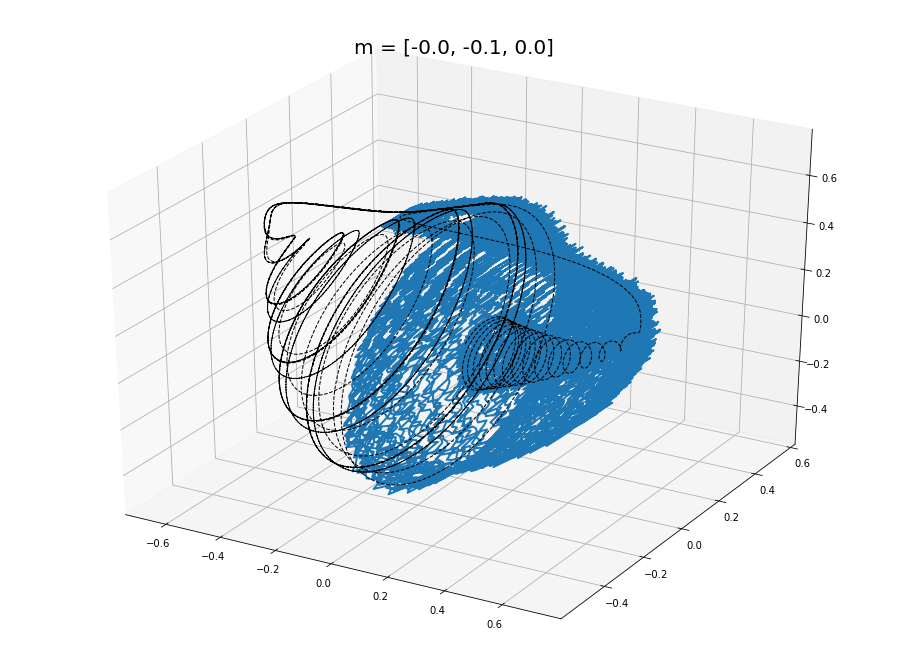

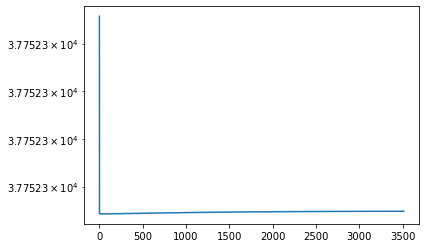

In [4]:
# Plot the results
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'},figsize=(16,12))
ax.plot(x_t[:,0], x_t[:,1], x_t[:,2],linewidth=2)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
x_pred = model.simulate(x0_train, t, integrator_kws=integrator_keywords)
if np.all(eigvals < 0.0):
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'k--', linewidth=1)
    ax.set_title('m = [{0:.1f}, '.format(opt_m[0]) + '{0:.1f}, '.format(opt_m[1]) + '{0:0.1f}]'.format(opt_m[2]), fontsize=20)
else:
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'g--', linewidth=2)

plt.figure(200)
plt.semilogy(sindy_opt.objective_history[1:])

In [5]:
# Check energy-preserving constraint is satisfied (Qijk + Qjik + Qkij = 0)
# and Cw = d

Ls = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
Qsum = np.sum(Q + np.transpose(Q, [0, 2, 1]) + np.transpose(Q, [2, 1, 0]))
print(Q + np.transpose(Q, [0, 2, 1]) + np.transpose(Q, [2, 1, 0]))
print(np.dot(constraint_matrix, Xi.flatten()))

[[[ 1.76751692e-16  2.66453526e-15  4.44089210e-16]
  [ 2.66453526e-15  2.77555756e-16  3.19189120e-16]
  [ 4.44089210e-16  3.19189120e-16 -1.44328993e-15]]

 [[ 2.66453526e-15  2.77555756e-16  3.19189120e-16]
  [ 2.77555756e-16  1.28122503e-15  1.11022302e-15]
  [ 3.19189120e-16  1.11022302e-15  8.88178420e-16]]

 [[ 4.44089210e-16  3.19189120e-16 -1.44328993e-15]
  [ 3.19189120e-16  1.11022302e-15  8.88178420e-16]
  [-1.44328993e-15  8.88178420e-16  7.57662262e-16]]]
[ 5.89172307e-17  4.27075009e-16  2.52554087e-16  2.77555756e-16
 -1.44328993e-15  8.88178420e-16  2.66453526e-15  4.44089210e-16
  1.11022302e-15  6.38378239e-16]


In [6]:
# Repeat with accelerated prox-gradient descent
# Define the hyperparams and perform the optimization (regular prox-gradient)
sindy_opt = ps.clSR3(threshold=threshold, eta=eta, alpha_m=gamma, alpha_A=beta, vtol=1e-5, accel=True,
                            PL=PL_tensor, PQ=PQ_tensor, max_iter=40000, tol=1e-10,
                            thresholder="l1", eigmin=-1e50, eigmax=-0.01,
                            constraint_lhs=constraint_matrix,
                            constraint_rhs=constraint_zeros,
                            constraint_order="feature")

model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True),
        )
model.fit(x_t, t=t)
Xi = model.coefficients().T

# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
opt_m = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
eigvals, eigvecs = np.linalg.eig(As)
print('proxgrad, As eigvals: ', eigvals)
print(opt_m)
smallest_eigval = np.sort(eigvals)[0]
largest_eigval = np.sort(eigvals)[-1]
L = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2],[0])), opt_m)
Rm = np.sqrt(smallest_eigval/largest_eigval)*np.linalg.norm(d)
print(d, Rm)

model.print()
print(np.dot(constraint_matrix, (sindy_opt.history_[0]).T.flatten()))
print(np.dot(constraint_matrix, (sindy_opt.history_[1]).T.flatten()))

37749.495840374715 2.538652842341664e-05 2.2461592302033786
37750.11365717662 8.888572194359345e-10 2.2269210894785525
37750.11365922178 1.2563160527233599e-09 2.2269164410971523
37750.11365926754 1.2787667238983376e-09 2.2269163924806725
37750.113659268136 1.2794975737534949e-09 2.2269163918640955
37750.11365926815 1.2795214786405038e-09 2.226916391846929
37750.11365926815 1.279522261191808e-09 2.226916391846401
proxgrad, As eigvals:  [-0.27605354 -0.00977603 -0.00954769]
[ 0.00795855 -0.05039615  0.00787699]
[ 0.00036954  0.00047643 -0.00161828] 0.00928602892603993
x0' = 0.048 x0 + -0.002 x1 + -0.001 x2 + 1.146 x0x1 + 0.015 x0x2 + -0.004 x1x2 + -0.008 x1x1
x1' = 0.013 x0 + -0.012 x1 + 2.968 x2 + 0.008 x0x1 + 0.080 x0x2 + -1.935 x1x2 + -1.146 x0x0 + -4.938 x2x2
x2' = 0.007 x0 + -2.964 x1 + -0.009 x2 + -0.075 x0x1 + 4.938 x1x2 + -0.015 x0x0 + 1.935 x1x1
[-0.00495633 -0.04421881  0.00459412  0.08379232  0.0165494   0.07478253
 -0.13874134 -0.02537259  0.05754624  0.11900496]
[-3.0955126

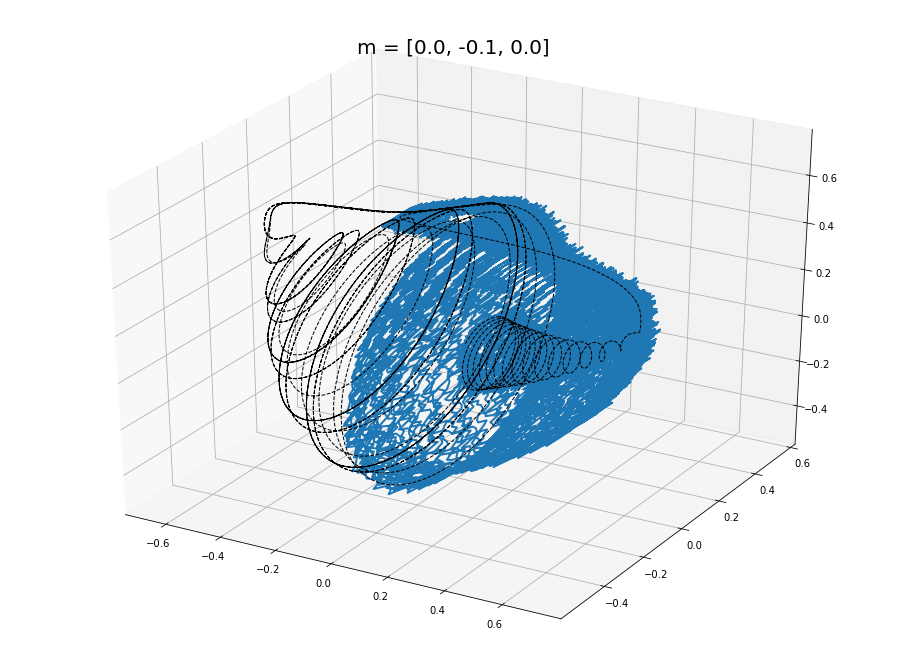

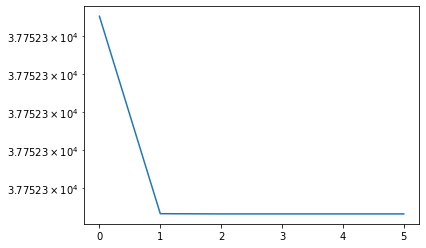

In [7]:
# Plot the results
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'},figsize=(16,12))
ax.plot(x_t[:,0], x_t[:,1], x_t[:,2],linewidth=2)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
x_pred = model.simulate(x0_train, t, integrator_kws=integrator_keywords)
if np.all(eigvals < 0.0):
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'k--', linewidth=1)
    ax.set_title('m = [{0:.1f}, '.format(opt_m[0]) + '{0:.1f}, '.format(opt_m[1]) + '{0:0.1f}]'.format(opt_m[2]), fontsize=20)
else:
    ax.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'g--', linewidth=2)

plt.figure(200)
plt.semilogy(sindy_opt.objective_history[1:])

### Note accelerated prox-gradient only took 5 steps instead of ~4000!!